In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from importlib import reload
from datetime import datetime
import tensorflow as tf
import time


# get the relative path
pref                = os.getcwd()

os.environ["RL_PATH"]   = pref

if f'{pref}/RLLibrary' not in sys.path:
    sys.path.append(f'{pref}/RLLibrary')

In [2]:
import pandas as pd
import numpy as np
import os
import shutil

In [3]:
from RLLibrary.utils import constants

In [4]:
from RLLibrary.FinUseCases.OrderExecution import EnvironmentManager
from RLLibrary.FinUseCases.OrderExecution import ExecutionAlgos
from RLLibrary.utils import constants as constants


dict_values([EnvSpec(PortfolioManagement-v0), EnvSpec(PortfolioManagement_CNN-v0), EnvSpec(OrderExecution-v0)])


In [5]:
reload(ExecutionAlgos)
reload(EnvironmentManager)

dict_values([EnvSpec(PortfolioManagement-v0), EnvSpec(PortfolioManagement_CNN-v0), EnvSpec(OrderExecution-v0)])


<module 'RLLibrary.FinUseCases.OrderExecution.EnvironmentManager' from '/Users/ankitgupta/Documents/git/anks/MachineLearning/ReinforcementLearning/RLLibrary/FinUseCases/OrderExecution/EnvironmentManager.py'>

In [6]:
DATA_DIR = constants.DATA_DIR
MODEL_DIR = constants.MODEL_DIR

path = os.path.join(MODEL_DIR, "OrderExecution")    
path = os.path.join(path, "DQN")

if not os.path.exists(path):
    os.makedirs(path)

path = os.path.join(path, "FF")

In [7]:
args = {"ticker": "RELIANCE", "trainingYear": ["2018" , "2019"], \
            "penalizeFactors": {"Impact": -100, "StepReward": 0.1}}

stgy = ExecutionAlgos.Execution_DQN(envName = "OrderExecution-v0", **args)



In [8]:
from RLLibrary.FinUseCases.OrderExecution.ModelManager.DQN import Agent as DQNAgent

In [9]:
reload(DQNAgent)

<module 'RLLibrary.FinUseCases.OrderExecution.ModelManager.DQN.Agent' from '/Users/ankitgupta/Documents/git/anks/MachineLearning/ReinforcementLearning/RLLibrary/FinUseCases/OrderExecution/ModelManager/DQN/Agent.py'>

In [10]:
save_dir = os.path.join(MODEL_DIR, "OrderExecution")
MAX_EPISODES = 1
DQNModel = None
hiddenUnits = [32]
batchNormalization = True
dropout_rate = 0.25
optimizer_learning_rate = 1e-4
clipvalue = 100


networkArgs = {"Model": DQNModel, "hiddenUnits": hiddenUnits, "batchNormalization": batchNormalization, \
                "dropout_rate" : dropout_rate, "optimizer_learning_rate": optimizer_learning_rate, "clipvalue": clipvalue}


stgy.agent = DQNAgent.DQN(envName = stgy.envName, save_dir = save_dir, \
                            networkArgs = networkArgs,  **stgy.envargs)


Loading Data for 2018
Loading Data for 2019
Model: "nn_ff"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1056      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  693       
Total params: 1,877
Trainable params: 1,813
Non-trainable params: 64
_________________________________________________________________
None
Model: "nn_ff_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  105

In [11]:
from RLLibrary.FinUseCases.OrderExecution.ModelManager.DQN.Agent import epsilon_exploration

In [13]:
#print("Episode", ep)
ep_reward = 0
ep_steps = 0
done = False

stgy.agent.env.reset()

current_state = stgy.agent.env.observation_space.currentState


In [14]:
action = 10
new_state, reward, done, _ = stgy.agent.env.step(action)
reward

3.17

In [17]:
(action*stgy.agent.env.orderSizeFactor/stgy.agent.env.currentInfo.Volume)**2. * 100

1.0342556966984768

In [16]:
action*stgy.agent.env.orderSizeFactor

5000

In [42]:

eps         = epsilon_exploration(nbFrames=0)
totalFrames = 0
discount_factor = 0.99


batch_size = 32
episodic_rewards = []

grads = None
MAX_EPISODES = 1
for ep in range(MAX_EPISODES):

    print("Episode", ep)
    ep_reward = 0
    ep_steps = 0
    done = False

    stgy.agent.env.reset()

    current_state = stgy.agent.env.observation_space.currentState

    while not done:

        # get action
        current_state = np.array(current_state).reshape(1, stgy.agent.env.observation_space.n)


        trainingRequired = False
        laststep = False
        if ep_steps % stgy.agent.env.TimeGapbetweenIntervals == 0:
            # take model defined action 
            actionIndex = stgy.agent.getAction(current_state, eps, mode = "TRAIN"    )
            action = stgy.agent.env.action_space.actions[actionIndex]
            
            actionIndex = 0
            action = 0
            trainingRequired = True




        if stgy.agent.env.currentInfo.TimeLeft == 1:
            # if only 1 minute left, execute all remaining orders

            action = stgy.agent.env.currentInfo.AvailableInventory/ stgy.agent.env.orderSizeFactor
            actionIndex = action            # in this case, action and actionIndex are same
            trainingRequired =True
            print("Executing remaining order", action)
            laststep = True


        if trainingRequired:
            new_state, reward, done, _ = stgy.agent.env.step(action)
            if laststep:
                print("Executing remaining order", action, "index", actionIndex, "remaining", stgy.agent.env.currentInfo.AvailableInventory, done)


            # store into experience replay
            stgy.agent.updateMemory(current_state, actionIndex, reward, new_state, done)

            # train teh model
            grads = stgy.agent.learn(done, episodeCount = ep, discount_factor = discount_factor, batch_size = batch_size)
            ep_reward += reward
            # Logger.info(f'Ep#: {ep} Reward:{reward} Action: {action} Steps: {ep_steps} leftSize: {self.env.currentInfo.AvailableInventory}    penality factor: {self.env.RewardManager.impactPenalizeFactor} {action} {self.env.orderSizeFactor} '   )

        else:
            action = 0
            new_state, _ , done, _ = stgy.agent.env.step(action)


        # update state
        ep_steps += 1
        current_state = new_state


    finishTime = time.perf_counter()

    # update Logs

    # get final portfolio value
#     orderHistory = stgy.agent.env.getInventoryHistory()
#     inventory = orderHistory["AvailableInventory"].iloc[-1]


Episode 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Action 0
Act

In [30]:
samples = random.sample(stgy.agent.memory.memory, batch_size)


# for all experience in batchsize
curStates       = np.array([tup[0][0] for tup in samples])
actions         = np.array([int(tup[1]) for tup in samples])
nextStates      = np.array([tup[2] for tup in samples])
rewards         = np.array([tup[3] for tup in samples])
done            = np.array([tup[4] for tup in samples])

# Add pre-processing step if needed

inputStates     = np.array(curStates).reshape(len(curStates), stgy.agent.env.observation_space.n)
nextStates      = np.array(nextStates).reshape(len(nextStates), stgy.agent.env.observation_space.n)

# ------ For DQN, target comes from the target model
# using bellman equation 

# Steps:
# 1. use target model to set the target. 
# 2. This target needs to be updated based on the bellman equation
# 2.1. Bellman Equation 1: get the max Q values for next state in the bellman equation


curr_q_vaues    = stgy.agent.train_model(inputStates) 
new_q_values    = stgy.agent.target_model(nextStates) 

# -----DQN algo ------
# vectorized computation

target          = rewards + discount_factor * np.amax(new_q_values, axis=1)
target[done]    = rewards[done]            # end state target is reward itself

target_f        = curr_q_vaues.numpy().copy()


In [31]:
target_f.shape

(32, 21)

In [32]:
actions

array([ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [18]:
target_f[range(batch_size), actions]

array([ 0.3022187 ,  0.18379895,  0.11962121, -0.05420659, -0.18451208,
        0.1926317 , -0.23073354,  0.30779052, -0.01637991, -0.04174974,
        0.2126154 , -0.52619237,  0.36619782,  0.17128167,  0.24842678,
        0.39681095, -0.07346999,  0.32926083,  0.80459636,  0.27718922,
        0.10671678,  0.23389345, -0.04841739, -0.11149358, -0.0315684 ,
        0.03399301,  0.17515258, -0.04098229,  0.07166208,  0.02889245,
        0.10766726,  0.4003131 ], dtype=float32)

In [28]:
target_f[range(batch_size), actions] = target


IndexError: arrays used as indices must be of integer (or boolean) type

In [43]:
stgy.agent.env.getInventoryHistory()

,Time,OpenInventory,TimeLeft,ExecutedInventory,ExecutedPrice,AvailableInventory
0,09:30,10000,100,0.0,NaN,10000.0
1,09:31,10000,99,0.0,1206.75,10000.0
2,09:32,10000,98,0.0,1207.15,10000.0
3,09:33,10000,97,0.0,1207.95,10000.0
4,09:34,10000,96,0.0,1209.40,10000.0
...,...,...,...,...,...,...
96,11:06,10000,4,0.0,1207.55,10000.0
97,11:07,10000,3,0.0,1208.00,10000.0
98,11:08,10000,2,0.0,1208.95,10000.0
99,11:09,10000,1,0.0,1208.40,10000.0


array([1153.15, 1153.35, 1152.65, 1152.95])

In [188]:
a.loadData()

Loading Data for 2018
Loading Data for 2019
Loading Data for 2020


In [189]:
a.getVolumeStats()

In [192]:
import matplotlib.pyplot as plt

In [191]:
a.VolumeStats.std

50302.118086978924

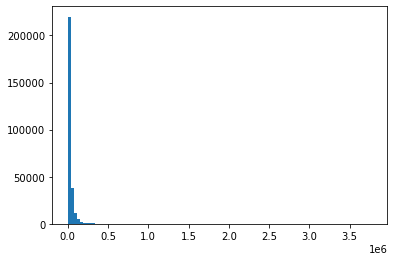

In [195]:
b = plt.hist(a.VolumeStats.Data, bins = 100)

In [369]:
reload(EnvironmentManager)

<module 'RLLibrary.FinUseCases.OrderExecution.EnvironmentManager' from '/Users/ankitgupta/Documents/git/anks/MachineLearning/ReinforcementLearning/RLLibrary/FinUseCases/OrderExecution/EnvironmentManager.py'>

In [370]:
a = EnvironmentManager.OrderExecution(ticker = "RELIANCE", trainingYear=["2018"])

Loading Data for 2018
998.25


In [371]:
# a.reset()

In [372]:
a.getInventoryHistory()

,Time,OpenInventory,TimeLeft,ExecutedInventory,ExecutedPrice,AvailableInventory
0,09:30,10000,100,0,NaN,10000


In [376]:
a.observation_space.n

32

In [375]:
a.envData[1][:4], a.envData[1][:4]/998.25

(array([[998.25, 998.95, 996.15, 998.  ],
        [997.55, 998.  , 995.15, 995.45],
        [995.6 , 997.55, 995.35, 997.55],
        [997.7 , 998.  , 997.55, 997.65]]),
 array([[1.        , 1.00070123, 0.99789632, 0.99974956],
        [0.99929877, 0.99974956, 0.99689457, 0.99719509],
        [0.99734535, 0.99929877, 0.99709492, 0.99929877],
        [0.99944904, 0.99974956, 0.99929877, 0.99939895]]))

In [367]:
875 * 0.9989217252396166

874.0565095846646

In [340]:
a.currentInfo.Index, a.currentInfo.Time, a.envData[1][0][0]

(14, '09:30', 1244.0)

In [341]:
newState, reward, over, _ = a.step(action = 500)

In [342]:
reward

-525.0

In [294]:
a.getInventoryHistory()

,Time,OpenInventory,TimeLeft,ExecutedInventory,ExecutedPrice,AvailableInventory
0,09:30,10000,100,0,NaN,10000
1,09:31,10000,99,500,1263.0,9500


In [377]:
#### Load the DQN Agent

In [381]:


from RLLibrary.FinUseCases import CustomGym
from RLLibrary.utils import constants as constants
DATA_DIR = constants.DATA_DIR
MODEL_DIR = constants.MODEL_DIR

# ------register PortfolioManagement environment onto Custom gym

CustomGym.register(
    id = "OrderExecution-v0",
    entry_point = 'FinUseCases.OrderExecution.EnvironmentManager:OrderExecution',
    kwargs = {"ticker": "RELIANCE", \
                "orderConfig": {"initialOrderSize": 10000, "initialTimeHorizon": 100, "orderFactor": 100, \
                                "TotalIntervals": 50, "startTime": "09:30", "Timezone": "IST"}, \

                "nbHistory" : 15, \
                "trainingYear" : [], "testDate" : None, \
                "dataPath" : os.path.join(DATA_DIR, "OrderExecution"), \
                'penalizeFactors' : {"Impact": -0.01}})




In [380]:
from RLLibrary.FinUseCases.OrderExecution.ModelManager.DQN import Agent

In [385]:
reload(Agent)

<module 'RLLibrary.FinUseCases.OrderExecution.ModelManager.DQN.Agent' from '/Users/ankitgupta/Documents/git/anks/MachineLearning/ReinforcementLearning/RLLibrary/FinUseCases/OrderExecution/ModelManager/DQN/Agent.py'>

In [386]:

env_args = {"ticker": "RELIANCE", "trainingYear": ["2018" , "2019"]}
envName = "OrderExecution-v0"
save_dir = MODEL_DIR
agent = Agent.DQN(envName, save_dir,  \
                    networkArgs  = {"Model": None, "hiddenUnits": [32], \
                        "batchNormalization": True, "dropout_rate" : 0.25, "optimizer_learning_rate": 1e-4, "clipvalue": 100},
                        **env_args)

Loading Data for 2018
Loading Data for 2019
Model: "nn_ff_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  1056      
_________________________________________________________________
batch_normalization_2 (Batch multiple                  128       
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  3333      
Total params: 4,517
Trainable params: 4,453
Non-trainable params: 64
_________________________________________________________________
None
Model: "nn_ff_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  1

In [387]:
agent.train(MAX_EPISODES = 500, discount_factor = 0.99, batch_size = 32)

  0%|          | 0/500 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1%|          | 4/500 [01:26<2:59:06, 21.67s/it]


KeyboardInterrupt: 

In [13]:
5e-6*(500*7)**2

61.25000000000001